# Time Travel

Now, let's show how LangGraph supports debugging by viewing, re-playing, and even forking from past states.

We call this time travel

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    print("Groq API key is not set in the environment variables.")
else:
    print("Groq API key successfully loaded.")

Groq API key successfully loaded.


In [4]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
llm_with_tools = llm.bind_tools(tools)

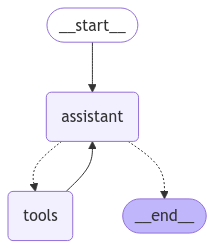

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}
# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    # Print the last message in the event
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1mpe)
 Call ID: call_1mpe
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

We can use get_state to look at the current state of our graph, given the thread_id!

In [7]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1mpe', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 'total_tokens': 392, 'completion_time': 0.069090909, 'prompt_time': 0.04164024, 'queue_time': 0.039912414, 'total_time': 0.110731149}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5699f288-d4c1-411b-9f1b-5b9d5bb0415c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_1mpe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 373, 'output_tokens': 19, 'total_tokens': 392}), ToolMessage(content='6', name='multiply', id='46be3580-9253-4e1c-8700-792053140ecf', tool_ca

We can also browse the state history of our agent.

get_state_history lets us get the state at all prior steps.

In [8]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

The first element is the current state, just as we got from get_state.

In [10]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-02-01T08:53:43.241399+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a20e-6e72-bfff-46e01fbe80d1'}}, tasks=(PregelTask(id='8a2528ab-c5dc-b478-708c-467744a0a4c1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1mpe', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 

## Replaying

In [11]:
to_replay = all_states[-2]

In [12]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-02-01T08:53:43.241399+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a20e-6e72-bfff-46e01fbe80d1'}}, tasks=(PregelTask(id='8a2528ab-c5dc-b478-708c-467744a0a4c1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1mpe', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 

In [13]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]}

In [14]:
to_replay.next

('assistant',)

In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_15pk)
 Call ID: call_15pk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking

What if we want to run from that same step, but with a different input.

This is forking.

In [17]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]

In [18]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}}

In [19]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [20]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe07b2-ea3e-6fd9-8001-9ab4e75c9f22'}}

In [21]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]

In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07b2-ea3e-6fd9-8001-9ab4e75c9f22'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}, created_at='2025-02-01T09:01:53.986932+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe07a0-a221-6cc3-8000-39ec5871edd7'}}, tasks=(PregelTask(id='901e1f3c-b989-d3d3-32f0-7fca1b49e0e8', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_d1kw)
 Call ID: call_d1kw
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b129149c-1ae8-4c35-bbcd-10805bd507d0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d1kw', 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 'total_tokens': 392, 'completion_time': 0.069090909, 'prompt_time': 0.044286393, 'queue_time': 0.024478376000000003, 'total_time': 0.113377302}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b50cb1c-57cd-45d0-90aa-1d0f5eb7c324-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_d1kw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 373, 'output_tokens': 19, 'total_tokens': 392}), ToolMessage(content='15', name='multiply', id='85b8435a-f431-4cd0-b0c0-4d35610668a